# Input Noise Analysis in Signal Chains

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import os
from numpy.polynomial import Polynomial
from scipy.signal import butter, filtfilt
import pandas as pd

############################################ Functions ############################################

def csv2array(file_name, folder_name, column_x_index, column_y_index=, starting_row, Delimiter):
    """
    Read a CSV file stored on a subfolder and extract data from two columns.

    @param file_name: String containing the name for the CSV file. Warning: Do include the .csv extension i.e. file_name = "Test.csv"
    @param folder_name: String containing the name for the subfloder containing said CSV file (Check the expected folder structure below).
    @param column_x_index: Int delimiting the index of the first column to extract, A=0, B=1....
    @param column_y_index: Int delimiting the index of the second column to extract.
    @param starting_row: The row index to start reading data from, row=1, 2...
    @param Delimiter: Separator between columns

    @return: A list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @note:Expected folder structure

    folder/
    ├── notebook.ipynb
    └── subfolder/
        ├── file1.csv
        ├── file2.csv
        └── file3.csv


    @Warning: If you copy the string from Windows file browser and dont want to change backslash for '/' read it as raw by writing an 'r' before the string path like so: 'csv2array(r"C:...'



    """
    
    # Arrays to store x and y values, in that order
    column_x_values = []
    column_y_values = []

    # Fix row indexing
    starting_row = starting_row - 1

    # Dynamicaly read the path to the file
    #folder_path = os.path.dirname(os.path.abspath("Analisis_Figuras_Paper.ipynb"))
    folder_path = os.getcwd()
    CSV_PATH = os.path.join(folder_path, folder_name, file_name)


    # Read the CSV file. 'with' statement handles closing the file correctly without using 'close'.
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file, delimiter = Delimiter)
        
        # Skip rows until the starting row
        for _ in range(starting_row):

            # next runs through an iterable
            next(reader)
        
        # Read rows until an empty cell is encountered
        for row in reader:
            if not row[column_x_index] or not row[column_y_index]:
                break  # Stop reading if either column has an empty cell
            
            # Values are read as strings, change commas for dots before casting to floats
            value_x = row[column_x_index].replace(',', '.')
            value_y = row[column_y_index].replace(',', '.')

            # Cast to floats
            column_x_values.append(float(value_x))
            column_y_values.append(float(value_y))

    # Also return a string containing the name of the data
    file_name = os.path.basename(CSV_PATH)
    file_name = os.path.splitext(file_name)[0]

    
    # Return the lists as arrays
    return [np.array(column_x_values), np.array(column_y_values), file_name]



def filter_data(order, cutoff_freq, data, Btype='low', graph=True):
    """
    Read a 2D array, design a butterworth filter, apply it and visualize it.

    This function is meant to be used in succession to csv2array, it applies a filter without delay and graphs the raw signals spectrum as well as the filtered one.
    This is done to aid in the design of the filter.

    @param order: order of the filter, since the filter is applied twice to achieve zero phase shift this is actualy half of the final order.
    @param cutoff_freq: cutoff frequency in Hz for the filter
    @param data: a list containing 2 arrays for x and y and a last element being the name of the file like so: [x, y]
    @param Btype: Type of filter for scipy's butter function
    @param graph: Boolean to decide wether to graph the results or not

    @return: a list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @Warning: Samples should be evenly spaced in time.
    """

    x_raw = data[0]
    y_raw = data[1]


    ################# Design Filter #########################################################################
    # Sampling frequency in Hz
    sampling_freq = 1 / (x_raw[1] - x_raw[0])

    # Convert cutoff frequency to a normalized value
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth filter
    b, a = butter(order, normalized_cutoff, btype=Btype, analog=False, output='ba')

    # Apply the filter using filtfilt to achieve zero-phase filtering
    y_filt = filtfilt(b, a, y_raw)


    ################# FFT #################################################################################
    # Compute the FFT of both the raw and filtered signals
    y_fft_raw = np.fft.fft(y_raw)
    y_fft_filt = np.fft.fft(y_filt)

    # Compute frequency array, same length and with sampling interval d=Delta x
    freq = np.fft.fftfreq(len(y_raw), d=(x_raw[1] - x_raw[0]))

    # Find the indices corresponding to the desired frequency range (0 to 1.0)
    freq_indices = np.where(np.logical_and(freq >= 0, freq <= 1000))



    ################# Plot ################################################################################
    # Clear the existing subplot and plot the FFT
    if (graph):
        # Create a figure with two subplots
        fig, axs = plt.subplots(2, 1)
        ax = axs[0]
         axs[0].clear()
        ax.plot(freq[freq_indices], np.abs(y_fft_raw[freq_indices]), linewidth=0.5, alpha=0.25, color="black")
         axs[0].plot(freq[freq_indices], np.abs(y_fft_filt[freq_indices]), linewidth=0.5, color="blue")
         axs[0].set_ylabel('Amplitude')
        ax.set_title('FFT of '+str(data[2]))
        ax.set_xlabel('Frequency [Hz]')

        # Plot raw vs filtered data
        ax = axs[1]
        ax.scatter(x_raw, y_raw, s=1, alpha=1, color="k")
        ax.plot(x_raw, y_filt, color="blue", linewidth=1)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.6)

        plt.show()

    return [x_raw, y_filt, data[2]]


## Magentic Sensor Detectivity Setup

#### Read Datasheet data from CSVs

In [2]:

# Dynamicaly read the path to the file
folder_path = os.getcwd()
folder_name = "Data"
file_name_0 = "HMC1001_noise.csv"
file_name_1 = "SR560_noise.csv"
file_name_2 = "TMR9003_noise.csv"
file_name_3 = "TMR9112_noise.csv"
file_name_4 = "INA217_G10_noise.csv"
file_name_5 = "INA217_G100_noise.csv"
file_name_9 = "INA_Short.csv"
file_name_10 = "INA_20Meg.csv"
CSV_PATH_0 = os.path.join(folder_path, folder_name, file_name_0)
CSV_PATH_1 = os.path.join(folder_path, folder_name, file_name_1)
CSV_PATH_2 = os.path.join(folder_path, folder_name, file_name_2)
CSV_PATH_3 = os.path.join(folder_path, folder_name, file_name_3)
CSV_PATH_4 = os.path.join(folder_path, folder_name, file_name_4)
CSV_PATH_5 = os.path.join(folder_path, folder_name, file_name_5)
CSV_PATH_9 = os.path.join(folder_path, folder_name, file_name_9)
CSV_PATH_10 = os.path.join(folder_path, folder_name, file_name_10)

# Read the CSV file with the correct delimiter (semicolon in this case)
HMC1001_df = pd.read_csv(CSV_PATH_0, sep='\t')
SR560_df = pd.read_csv(CSV_PATH_1, sep='\t')
TMR9003_df = pd.read_csv(CSV_PATH_2, sep='\t')
TMR9112_df = pd.read_csv(CSV_PATH_3, sep='\t')
INA217_G10_df = pd.read_csv(CSV_PATH_4, sep='\t')
INA217_G100_df = pd.read_csv(CSV_PATH_5, sep='\t')
INAShort_df = pd.read_csv(CSV_PATH_9, sep=',')
INA22Meg_df = pd.read_csv(CSV_PATH_10, sep=',')

# Replace empty strings with NaN
HMC1001_df = HMC1001_df.replace('', pd.NA)
SR560_df = SR560_df.replace('', pd.NA)
TMR9003_df = TMR9003_df.replace('', pd.NA)
TMR9112_df = TMR9112_df.replace('', pd.NA)
INA217_G10_df = INA217_G10_df.replace('', pd.NA)
INA217_G100_df = INA217_G100_df.replace('', pd.NA)
INAShort_df = INAShort_df.replace('', pd.NA)
INA22Meg_df = INA22Meg_df.replace('', pd.NA)

# Drop columns that contain only missing values (NaN)
HMC1001_df = HMC1001_df.dropna(axis=1, how='all')
SR560_df = SR560_df.dropna(axis=1, how='all')
TMR9003_df = TMR9003_df.dropna(axis=1, how='all')
TMR9112_df = TMR9112_df.dropna(axis=1, how='all')
INA217_G10_df = INA217_G10_df.dropna(axis=1, how='all')
INA217_G100_df = INA217_G100_df.dropna(axis=1, how='all')
INAShort_df = INAShort_df.dropna(axis=1, how='all')
INA22Meg_df = INA22Meg_df.dropna(axis=1, how='all')

# Convert decimal commas to decimal points
HMC1001_df["Frec"] = [float(str(i).replace(",", ".")) for i in HMC1001_df["Frec"]]
HMC1001_df["PSD"] = [float(str(i).replace(",", ".")) for i in HMC1001_df["PSD"]]
SR560_df["Frec"] = [float(str(i).replace(",", ".")) for i in SR560_df["Frec"]]
SR560_df["PSD"] = [float(str(i).replace(",", ".")) for i in SR560_df["PSD"]]
TMR9003_df["Frec"] = [float(str(i).replace(",", ".")) for i in TMR9003_df["Frec"]]
TMR9003_df["PSD"] = [float(str(i).replace(",", ".")) for i in TMR9003_df["PSD"]]
TMR9112_df["Frec"] = [float(str(i).replace(",", ".")) for i in TMR9112_df["Frec"]]
TMR9112_df["PSD"] = [float(str(i).replace(",", ".")) for i in TMR9112_df["PSD"]]
INA217_G10_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA217_G10_df["Frec"]]
INA217_G10_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA217_G10_df["PSD"]]
INA217_G100_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA217_G100_df["Frec"]]
INA217_G100_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA217_G100_df["PSD"]]
INAShort_df["Frec"] = [float(str(i).replace(",", ".")) for i in INAShort_df["Frec"]]
INAShort_df["PSD"] = [float(str(i).replace(",", ".")) for i in INAShort_df["PSD"]]
INA22Meg_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA22Meg_df["Frec"]]
INA22Meg_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA22Meg_df["PSD"]]

INA22Meg_df

,Frec,PSD
0,0.0,1.520000e-04
1,1.0,1.120000e-08
2,2.0,8.010000e-09
3,3.0,5.930000e-09
4,4.0,5.580000e-09
...,...,...
38395,38400.0,6.020000e-09
38396,38400.0,5.350000e-09
38397,38400.0,5.100000e-09
38398,38400.0,5.170000e-09


#### Read Simulation data from txt

In [3]:

# Dynamicaly read the path to the file
file_name_6 = "HMC1001Sim.txt"
file_name_8 = "InputNoiseWholeChaingINAG100INAandSRTheoretical.txt"
CSV_PATH_6 = os.path.join(folder_path, folder_name, file_name_6)
CSV_PATH_8 = os.path.join(folder_path, folder_name, file_name_8)

# Read the CSV file with the correct delimiter (semicolon in this case)
HMC1001Sim_df = pd.read_csv(CSV_PATH_6, sep='\t')
VinTheorSim_df = pd.read_csv(CSV_PATH_8, sep='\t')

# Rename Headers to match those from CSVs
HMC1001Sim_df.columns = ["Frec", "PSD"]
VinTheorSim_df.columns = ["Frec", "PSD"]

VinTheorSim_df


,Frec,PSD
0,0.100000,3.660418e-08
1,0.102329,3.618663e-08
2,0.104713,3.577387e-08
3,0.107152,3.536586e-08
4,0.109648,3.496254e-08
...,...,...
496,9120.108394,2.153216e-09
497,9332.543008,2.153139e-09
498,9549.925860,2.153063e-09
499,9772.372210,2.152989e-09


#### Read data to calculate input noise from stages

In [4]:

# Dynamicaly read the path to the file
file_name_7 = "ADC_Short.csv"
file_name_8 = "ADC_High_R.csv"
CSV_PATH_7 = os.path.join(folder_path, folder_name, file_name_7)
CSV_PATH_8 = os.path.join(folder_path, folder_name, file_name_8)

# Read the CSV file with the correct delimiter (semicolon in this case)
ADC_Short_df = pd.read_csv(CSV_PATH_7, sep=',')
ADC_High_R_df = pd.read_csv(CSV_PATH_8, sep=',')

# Replace empty strings with NaN
ADC_Short_df = ADC_Short_df.replace('', pd.NA)
ADC_Short_df = ADC_Short_df.replace('', pd.NA)


# Drop columns that contain only missing values (NaN)
ADC_Short_df = ADC_Short_df.dropna(axis=1, how='all')
ADC_High_R_df = ADC_High_R_df.dropna(axis=1, how='all')

# Convert decimal commas to decimal points
ADC_Short_df["Frec"] = [float(str(i).replace(",", ".")) for i in ADC_Short_df["Frec"]]
ADC_Short_df["PSD"] = [float(str(i).replace(",", ".")) for i in ADC_Short_df["PSD"]]
ADC_High_R_df["Frec"] = [float(str(i).replace(",", ".")) for i in ADC_High_R_df["Frec"]]
ADC_High_R_df["PSD"] = [float(str(i).replace(",", ".")) for i in ADC_High_R_df["PSD"]]
VinTheorSim_df["Frec"] = [float(str(i).replace(",", ".")) for i in VinTheorSim_df["Frec"]]
VinTheorSim_df["PSD"] = [float(str(i).replace(",", ".")) for i in VinTheorSim_df["PSD"]]

VinTheorSim_df

,Frec,PSD
0,0.100000,3.660418e-08
1,0.102329,3.618663e-08
2,0.104713,3.577387e-08
3,0.107152,3.536586e-08
4,0.109648,3.496254e-08
...,...,...
496,9120.108394,2.153216e-09
497,9332.543008,2.153139e-09
498,9549.925860,2.153063e-09
499,9772.372210,2.152989e-09


#### Analyze wether we can measure without the homebrewed INA stage

In [5]:
# Store dataframes into lists, first list is for frequencies, second for PSDs
HMC1001_arr = [[], []]
SR560_arr = [[], []]
TMR9003_arr = [[], []]
TMR9112_arr = [[], []]
INA217_G10_arr = [[], []]
INA217_G100_arr = [[], []]
HMC1001Sim_arr = [[], []]
ADC_Short_arr = [[], []]
ADC_High_R_arr = [[], []]
VinTheorSim_arr = [[], []]
INAShort_arr = [[], []]
INA22Meg_arr = [[], []]

# Cast strings to floats
HMC1001_arr[0], HMC1001_arr[1] = HMC1001_df["Frec"].values, HMC1001_df["PSD"].values
SR560_arr[0], SR560_arr[1] = SR560_df["Frec"].values, SR560_df["PSD"].values
TMR9003_arr[0], TMR9003_arr[1] = TMR9003_df["Frec"].values, TMR9003_df["PSD"].values
TMR9112_arr[0], TMR9112_arr[1] = TMR9112_df["Frec"].values, TMR9112_df["PSD"].values
INA217_G10_arr[0], INA217_G10_arr[1] = INA217_G10_df["Frec"].values, INA217_G10_df["PSD"].values
INA217_G100_arr[0], INA217_G100_arr[1] = INA217_G100_df["Frec"].values, INA217_G100_df["PSD"].values
HMC1001Sim_arr[0], HMC1001Sim_arr[1] = HMC1001Sim_df["Frec"].values, HMC1001Sim_df["PSD"].values
ADC_Short_arr[0], ADC_Short_arr[1] = ADC_Short_df["Frec"].values, ADC_Short_df["PSD"].values
ADC_High_R_arr[0], ADC_High_R_arr[1] = ADC_High_R_df["Frec"].values, ADC_High_R_df["PSD"].values
VinTheorSim_arr[0], VinTheorSim_arr[1] = VinTheorSim_df["Frec"].values, VinTheorSim_df["PSD"].values
INAShort_arr[0], INAShort_arr[1] = INAShort_df["Frec"].values, INAShort_df["PSD"].values
INA22Meg_arr[0], INA22Meg_arr[1] = INA22Meg_df["Frec"].values, INA22Meg_df["PSD"].values

In [6]:
# Align data

# Generate an array of N frequencies encasing all curves
N = 5000
common_freqs = np.linspace(min(min(SR560_arr[0]), min(HMC1001_arr[0])), max(max(SR560_arr[0]), max(HMC1001_arr[0])), N)

# Since sampled data is missaligned generate new data by interpolation at the common frequencies
SR560_aligned = np.interp(common_freqs, HMC1001_arr[0], HMC1001_arr[1])
HMC1001_aligned = np.interp(common_freqs, SR560_arr[0], SR560_arr[1])
TMR9003_aligned = np.interp(common_freqs, TMR9003_arr[0], TMR9003_arr[1])
TMR9112_aligned = np.interp(common_freqs, TMR9112_arr[0], TMR9112_arr[1])
INA217_G10_aligned = np.interp(common_freqs, INA217_G10_arr[0], INA217_G10_arr[1])
INA217_G100_aligned = np.interp(common_freqs, INA217_G100_arr[0], INA217_G100_arr[1])
HMC1001Sim_aligned = np.interp(common_freqs, HMC1001Sim_arr[0], HMC1001Sim_arr[1])
ADC_Short_aligned = np.interp(common_freqs, ADC_Short_arr[0], ADC_Short_arr[1])
ADC_High_R_aligned = np.interp(common_freqs, ADC_High_R_arr[0], ADC_High_R_arr[1])
VinTheorSim_aligned = np.interp(common_freqs, VinTheorSim_arr[0], VinTheorSim_arr[1])
INAShort_aligned = np.interp(common_freqs, INAShort_arr[0], INAShort_arr[1])
INA22Meg_aligned = np.interp(common_freqs, INA22Meg_arr[0], INA22Meg_arr[1])


In [7]:
# Gain correction for high impedance measurements
INA22Meg_aligned = 1.37 * INA22Meg_aligned
ADC_High_R_aligned = 1.37 *ADC_High_R_aligned

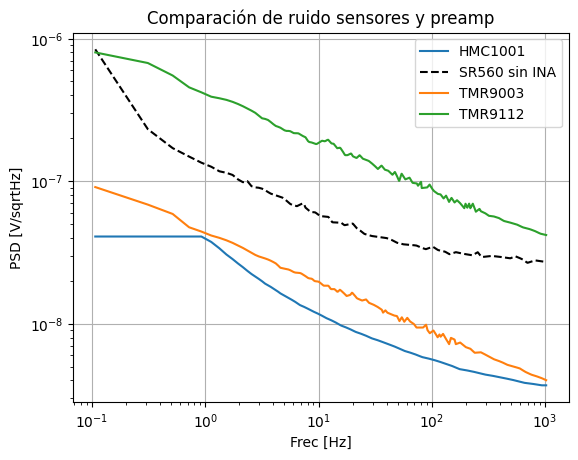

In [8]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax.plot(common_freqs, SR560_aligned, color='k', linestyle="dashed", label='SR560 sin INA')
#ax.plot(common_freqs, INA217_G10_aligned, color='k', linestyle="dashed", label='INA217 G=10')
#ax.plot(common_freqs, INA217_G100_aligned, color='r', linestyle="dashed", label='INA217 G=100')
ax.plot(common_freqs, TMR9003_aligned, label='TMR9003')
ax.plot(common_freqs, TMR9112_aligned, label='TMR9112')

# Log plot
ax.set_xscale('log')
ax.set_yscale('log')

# Customize the plot
ax.set_xlabel('Frec [Hz]')
ax.set_ylabel('PSD [V/sqrtHz]')
ax.set_title('Comparación de ruido sensores y preamp')
ax.grid()
'''
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)
'''
ax.legend()

# Display the figure
plt.show()

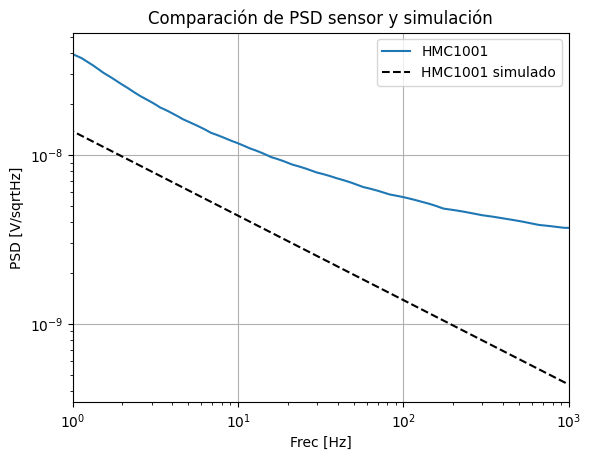

In [9]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax.plot(common_freqs, HMC1001Sim_aligned, color='k', linestyle="dashed", label='HMC1001 simulado')

# Log plot
ax.set_xscale('log')
ax.set_yscale('log')

# Customize the plot
ax.set_xlabel('Frec [Hz]')
ax.set_ylabel('PSD [V/sqrtHz]')
ax.set_title('Comparación de PSD sensor y simulación')
ax.grid()
ax.set_xlim(1, 1000)
'''
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)
'''
ax.legend()

# Display the figure
plt.show()

#### Calculate Noise floor for each sensor

In [10]:
index = 10
print((INA22Meg_aligned[index]**2))
print((INAShort_aligned[index]**2))
print((INA22Meg_aligned[index]**2) - (INAShort_aligned[index]**2))
print((4*(1.38E-23)*295.15*22E6) )
print((INA22Meg_aligned[index]**2) - (INAShort_aligned[index]**2) - (4*(1.38E-23)*295.15*22E6) )


1.1106716103222846e-16
2.978180647739821e-17
8.128535455483024e-17
3.5843016e-13
-3.5834887464544516e-13


In [11]:
# Calculate current and voltage sourcess of equivalent input noise for all setup as per de EnIn amplifier model
En = INAShort_aligned

In = []
for index in range(0, len(INA22Meg_aligned)):
    In.append(INA22Meg_aligned[index] / 22E6)
    #In.append( (1/(22E6)) * math.sqrt( (INA22Meg_aligned[index]**2) - ( (INAShort_aligned[index])**2) - (4*(1.38E-23)*295.15*22E6) ) )

R_HMC1001 = 860
R_TMR9003 = 50E3
R_TMR9112 = 50E3

HMC1001_Noisefloor = []
TMR9003_Noisefloor = []
TMR9112_Noisefloor = []
for index in range(0, len(INA22Meg_aligned)):
    HMC1001_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_HMC1001)**2 ))
    TMR9003_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_TMR9003)**2 ))
    TMR9112_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_TMR9112)**2 ))

<Figure size 640x480 with 0 Axes>

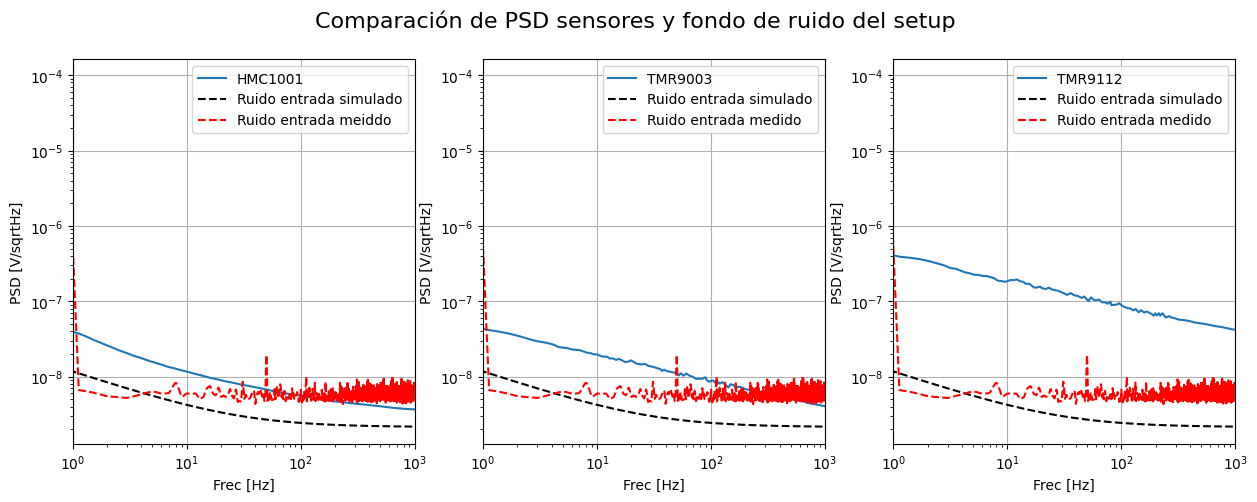

In [12]:
# Create a new figure
fig = plt.figure()

# Add a subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns, and custom figure size

# Plot data for first sensor
ax[0].plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax[0].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[0].plot(common_freqs, HMC1001_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada meiddo')

# Plot data for second sensor
ax[1].plot(common_freqs, TMR9003_aligned, label='TMR9003')
ax[1].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[1].plot(common_freqs, TMR9003_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada medido')

# Plot data for third sensor
ax[2].plot(common_freqs, TMR9112_aligned, label='TMR9112')
ax[2].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[2].plot(common_freqs, TMR9112_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada medido')

# Set a title for the whole figure
fig.suptitle('Comparación de PSD sensores y fondo de ruido del setup', fontsize=16)

for i in range(0, 3):
    # Log plot
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    # Customize the plot
    ax[i].set_xlabel('Frec [Hz]')
    ax[i].set_ylabel('PSD [V/sqrtHz]')
    ax[i].grid()
    ax[i].set_xlim(1, 1000)

    ax[i].legend()

# Display the figure
plt.show()

## Magentic Gradiometer Setup

We are going to calculate through the En-In method the equivalent noise refered to the input at every stage of the signal chain, we will assume that noise beyond each stage is negligible when refering noise to it's particular input.

In [101]:
# Extract data from measurements on csv file

# Naming convention for these measurements illustrates where the input of the chain has been severed, what has been placed at that input and holds an array with
# the corresponding voltage readings at the output of the chain
Freq = []
Whole_Chain = []
Gradiometer_with_cables_High_R = []
Gradiometer_with_cables_Short = []
Gradiometer_without_cables_High_R = []
Gradiometer_without_cables_Short = []
SR560_with_cables_Short = []
SR560_with_cables_High_R = []
DAQ_NI_6356_High_R = []
DAQ_NI_6356_Short = []

Freq, Whole_Chain, column_name = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=2, starting_row=7, Delimiter="\t")
_, Gradiometer_with_cables_High_R, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=3, starting_row=7, Delimiter="\t")
_, Gradiometer_with_cables_Short, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=4, starting_row=7, Delimiter="\t")
_, Gradiometer_without_cables_High_R, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=5, starting_row=7, Delimiter="\t")
_, Gradiometer_without_cables_Short, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=6, starting_row=7, Delimiter="\t")
_, SR560_with_cables_High_R, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=7, starting_row=7, Delimiter="\t")
_, SR560_with_cables_Short, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=8, starting_row=7, Delimiter="\t")
_, DAQ_NI_6356_High_R, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=9, starting_row=7, Delimiter="\t")
_, DAQ_NI_6356_Short, _ = csv2array(file_name="En_In_Measurement_Gradiometer.csv", folder_name="En_In_Measurement_Gradiometer_Data", column_x_index=1, column_y_index=10, starting_row=7, Delimiter="\t")


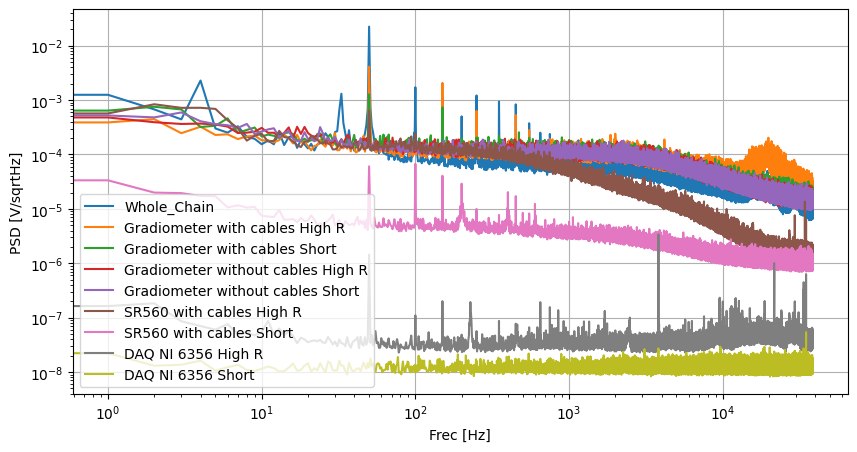

In [102]:
# At this point the data has not been treated and is not relevant but we can plot it to check that the previous step was succesful
plot_it = True

if(plot_it):
    # Create a new figure
    fig = plt.figure(figsize=(10, 5))

    # Add a subplot
    ax = fig.add_subplot(111)

    # Plot the data
    ax.plot(Freq, Whole_Chain, label='Whole_Chain')
    ax.plot(Freq, Gradiometer_with_cables_High_R, label='Gradiometer with cables High R')
    ax.plot(Freq, Gradiometer_with_cables_Short, label='Gradiometer with cables Short')
    ax.plot(Freq, Gradiometer_without_cables_High_R, label='Gradiometer without cables High R')
    ax.plot(Freq, Gradiometer_without_cables_Short, label='Gradiometer without cables Short')
    ax.plot(Freq, SR560_with_cables_High_R, label='SR560 with cables High R')
    ax.plot(Freq, SR560_with_cables_Short, label='SR560 with cables Short')
    ax.plot(Freq, DAQ_NI_6356_High_R, label='DAQ NI 6356 High R')
    ax.plot(Freq, DAQ_NI_6356_Short, label='DAQ NI 6356 Short')

    # Log plot
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Customize the plot
    ax.set_xlabel('Frec [Hz]')
    ax.set_ylabel('PSD [V/sqrtHz]')
    ax.grid()

    ax.legend()

    # Display the figure
    plt.show()

In [103]:
# The previous arrays contain voltage values measured at the output, to obtain noise and current values referenced to the input we have
# to divide by the whole system Gain and for the High R we will also divide by the resistance in place. These values are in the CSV file but 
# we'll grab them ourselves:

# Constant for all measurements where the Gradiometer was involved
Gradiometer_Gain = 9.97E3 * 199

# Variable for all measurements where the SR560 was involved.
# Order: Whole chain, Gradiometer with cables high R, Gradiometer with cables short, Gradiometer without cables High R, Gradiometer without cables short, SR560 High R, SR560 Short
SR560_preamp_Gain = [5000, 10000, 20000, 50000, 50000, 50000, 50000]
R_High = 1.52E6

# There is another issue when referencing back to input noise, we do have to divide by the whole system gain as we did the first time (above), what I didn't consider at the time is
# the SR560 filters are a part of system gain, a frequency dependent gain to solve this we'll design a function that gives total system Gain of the SR560 for a given frequency
def SR560_Gain(freq, G_preamp, f_hp=1, f_lp=3000):
    """
    Calculate the total system gain at a given frequency.

    Parameters:
    freq : float
        Frequency at which to calculate the gain (in Hz)
    G_preamp : float
        Gain of the preamplifier
    f_hp : float
        Cutoff frequency of the high-pass filter (in Hz, default is 1 Hz)
    f_lp : float
        Cutoff frequency of the low-pass filter (in Hz, default is 3000 Hz)

    Returns:
    G_total : float
        The total system gain at frequency freq
    """
    # Total SR560 is G_preamp * G_LP * G_HP 

    # High-pass filter gain at frequency freq
    G_hp = freq / np.sqrt(freq**2 + f_hp**2)
    
    # Low-pass filter gain at frequency f
    G_lp = f_lp / np.sqrt(freq**2 + f_lp**2)
    
    # Total system gain
    G_total = float(G_preamp) * G_hp * G_lp
    
    return G_total

# Then we can use the function to create an array for each of the gains in the SR560
SR560_Gains = []
for Gain in SR560_preamp_Gain:
    gain_buff = []
    for freq in Freq:
        gain_buff.append(SR560_Gain(freq, Gain))
    SR560_Gains.append(np.array(gain_buff))

# Hack: Because the acquisition software already tries to reference the output noise back 
# to the input and we had set it to incorrect values we have to first refer the data back 
# to the output thought these incorrect values and then we are set to properly refer back
# to input. A total system gian of 50 was assumed supousedly for all measurements
Whole_Chain = Whole_Chain * 50
Gradiometer_with_cables_High_R = Gradiometer_with_cables_High_R * 50
Gradiometer_with_cables_Short = Gradiometer_with_cables_Short * 50
Gradiometer_without_cables_High_R = Gradiometer_without_cables_High_R * 50
Gradiometer_without_cables_Short = Gradiometer_without_cables_Short * 50
SR560_with_cables_Short = SR560_with_cables_Short * 50
SR560_with_cables_High_R = SR560_with_cables_High_R * 50
DAQ_NI_6356_High_R = DAQ_NI_6356_High_R * 50
DAQ_NI_6356_Short = DAQ_NI_6356_Short * 50

# Now we are ready to reference each of the noise arrays to their respective input
'''
Whole_Chain = Whole_Chain / (Gradiometer_Gain * SR560_Gains[0])
Gradiometer_with_cables_High_R = Gradiometer_with_cables_High_R / (Gradiometer_Gain * SR560_Gains[1])
Gradiometer_with_cables_Short = Gradiometer_with_cables_Short / (Gradiometer_Gain * SR560_Gains[2])
Gradiometer_without_cables_High_R = Gradiometer_without_cables_High_R / (Gradiometer_Gain * SR560_Gains[3])
Gradiometer_without_cables_Short = Gradiometer_without_cables_Short / (Gradiometer_Gain * SR560_Gains[4])
SR560_with_cables_High_R = SR560_with_cables_High_R / (SR560_Gains[5])
SR560_with_cables_Short = SR560_with_cables_Short / (SR560_Gains[6])
DAQ_NI_6356_High_R = DAQ_NI_6356_High_R
DAQ_NI_6356_Short = DAQ_NI_6356_Short
'''
Whole_Chain = Whole_Chain / (Gradiometer_Gain * SR560_preamp_Gain[0])
Gradiometer_with_cables_High_R = Gradiometer_with_cables_High_R / (Gradiometer_Gain * SR560_preamp_Gain[1])
Gradiometer_with_cables_Short = Gradiometer_with_cables_Short / (Gradiometer_Gain * SR560_preamp_Gain[2])
Gradiometer_without_cables_High_R = Gradiometer_without_cables_High_R / (Gradiometer_Gain * SR560_preamp_Gain[3])
Gradiometer_without_cables_Short = Gradiometer_without_cables_Short / (Gradiometer_Gain * SR560_preamp_Gain[4])
SR560_with_cables_High_R = SR560_with_cables_High_R / (SR560_preamp_Gain[5])

SR560_with_cables_Short = SR560_with_cables_Short / (SR560_preamp_Gain[6])
DAQ_NI_6356_High_R = DAQ_NI_6356_High_R
DAQ_NI_6356_Short = DAQ_NI_6356_Short


# All voltages have now been referenced at the input, however there is one final step: The voltages for High R
# where measured employing a high resistance at the input so that the voltage contribution was mainly due to
# input noise current. Thus to obtain the current we simply divide all "High_R" measurements by said resistance
Gradiometer_with_cables_High_R = Gradiometer_with_cables_High_R / R_High
Gradiometer_without_cables_High_R = Gradiometer_without_cables_High_R / R_High
SR560_with_cables_High_R = SR560_with_cables_High_R / R_High
DAQ_NI_6356_High_R = DAQ_NI_6356_High_R / R_High


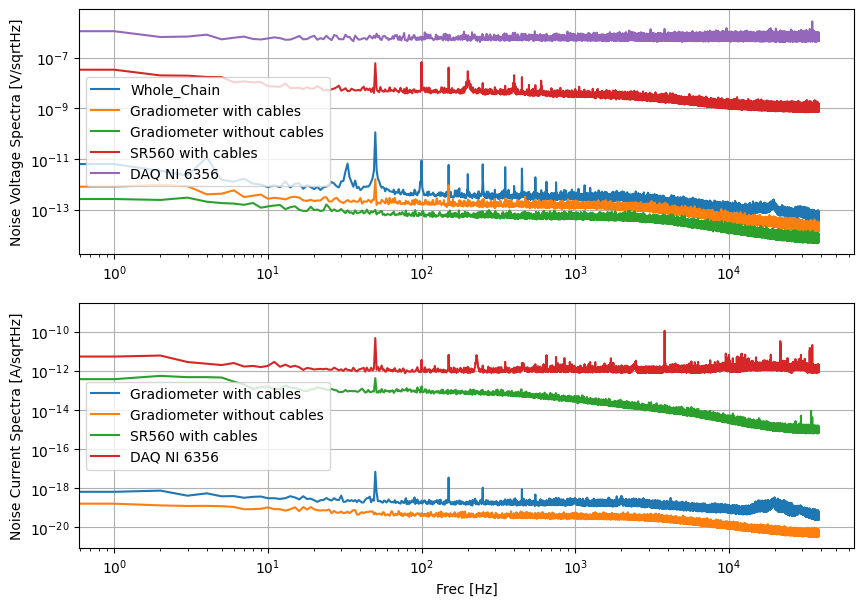

In [104]:
# Add a subplot
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Plot the data
axs[0].plot(Freq, Whole_Chain, label='Whole_Chain')
axs[0].plot(Freq, Gradiometer_with_cables_Short, label='Gradiometer with cables')
axs[0].plot(Freq, Gradiometer_without_cables_Short, label='Gradiometer without cables')
axs[0].plot(Freq, SR560_with_cables_Short, label='SR560 with cables')
axs[0].plot(Freq, DAQ_NI_6356_Short, label='DAQ NI 6356')


axs[1].plot(Freq, Gradiometer_with_cables_High_R, label='Gradiometer with cables')
axs[1].plot(Freq, Gradiometer_without_cables_High_R, label='Gradiometer without cables')
axs[1].plot(Freq, SR560_with_cables_High_R, label='SR560 with cables')
axs[1].plot(Freq, DAQ_NI_6356_High_R, label='DAQ NI 6356')



# Log plot
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# Customize the plot
axs[1].set_xlabel('Frec [Hz]')
axs[0].set_ylabel('Noise Voltage Spectra [V/sqrtHz]')
axs[1].set_ylabel('Noise Current Spectra [A/sqrtHz]')
axs[0].grid()
axs[1].grid()

axs[0].legend()
axs[1].legend()

# Display the figure
plt.show()